In [1]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support, roc_auc_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder

import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
"/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded.csv"

UK_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")


print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)


UK shape: (229782, 23)
US shape: (4032, 21)


In [3]:
# Print column names of UK_data
print("UK_data columns:", UK_data.columns.tolist())

# Print column names of US_data
print("US_data columns:", US_data.columns.tolist())

UK_data columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country', 'latitude', 'longitude']
US_data columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']


In [4]:
from tabulate import tabulate

# Display the first 5 rows of UK_data in a pretty table
print(tabulate(UK_data.head(), headers='keys', tablefmt='pretty'))

+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+----------------+---------+--------------------+-----------------+--------------------------+----------------+--------------------+---------------------------------+-------------------------+---------+-----------------+----------------+-----------+-----------+
|   |   Report ID   | Report Version |   Make   |  Model  | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |      City      |  State  |    Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |    Lighting    |     Crash With     | Highest Injury Severity Alleged |  SV Pre-Crash Movement  | Weather | SV Contact Area |    Country     | latitude  | longitude |
+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+-------

In [5]:
# Display the first 5 rows of UK_data in a pretty table
print(tabulate(US_data.head(), headers='keys', tablefmt='pretty'))

+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+-----------------+--------------------------+----------------------+-------------------------+---------------------------------+-----------------------+-----------+-----------------------+---------+
|   |  Report ID  | Report Version | Make |    Model     | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |     City      | State |   Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |       Lighting       |       Crash With        | Highest Injury Severity Alleged | SV Pre-Crash Movement |  Weather  |    SV Contact Area    | Country |
+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+--

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def prepare_data_fixed_target(uk_data, us_data, dataset='UK', test_size=0.2):
    data = uk_data.copy() if dataset.upper() == 'UK' else us_data.copy()
    target_col = 'Highest Injury Severity Alleged'
    
    # Encode target if not numeric
    if data[target_col].dtype == 'object' or str(data[target_col].dtype).startswith('category'):
        le = LabelEncoder()
        data[target_col] = le.fit_transform(data[target_col].astype(str))
        print(f"Encoded target '{target_col}' -> Classes: {list(le.classes_)}")
    else:
        print(f"'{target_col}' is already numeric.")
    
    # Drop non-predictive ID columns
    drop_cols = ['Report ID', 'Report Version']
    data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')
    
    # Frequency encode high-cardinality columns
    high_card_cols = ['City', 'State']
    for col in high_card_cols:
        if col in data.columns:
            freq_map = data[col].value_counts().to_dict()
            data[col] = data[col].map(freq_map)
            print(f"Frequency encoded '{col}' (unique: {len(freq_map)})")
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    # One-hot encode remaining categorical columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols:
        print("One-hot encoding categorical columns:", cat_cols)
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # Train-test split
    stratify = y if len(np.unique(y)) > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify
    )
    
    # Scale
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  index=X_test.index,  columns=X_test.columns)
    
    print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
    print("Class distribution in y_train:")
    print(pd.Series(y_train).value_counts().sort_index())
    
    return {
        'X_train': X_train, 'X_test': X_test,
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_test': y_test,
        'feature_names': X_train.columns.tolist(),
        'scaler': scaler,
        'target_col': target_col
    }

In [7]:
prep_uk = prepare_data_fixed_target(UK_data, US_data, dataset='UK')
print(prep_uk['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Serious']
Frequency encoded 'City' (unique: 4247)
Frequency encoded 'State' (unique: 4)
One-hot encoding categorical columns: ['Make', 'Model', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']
Shapes -> X_train: (183825, 3898) X_test: (45957, 3898)
Class distribution in y_train:
Highest Injury Severity Alleged
0      2831
1    142375
2     38619
Name: count, dtype: int64
        Model Year      City     State  Posted Speed Limit (MPH)  latitude  \
33762    -1.985062 -0.703968  0.321117                  0.164919 -0.988651   
68088     1.305034 -0.623151  0.321117                  2.271380  0.596615   
192453    0.025552 -0.237027  0.321117                 -1.239389 -0.694902   
174615   -1.436712 -0.214578  0.321117                 -0.53723

In [8]:
prep_us = prepare_data_fixed_target(UK_data, US_data, dataset='US')
print(prep_us['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Moderate', 'No Injuries Reported', 'Serious']
Frequency encoded 'City' (unique: 1299)
Frequency encoded 'State' (unique: 51)
One-hot encoding categorical columns: ['Make', 'Model', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']
Shapes -> X_train: (3225, 1714) X_test: (807, 1714)
Class distribution in y_train:
Highest Injury Severity Alleged
0     381
1     239
2      47
3    2427
4     131
Name: count, dtype: int64
      Model Year      City     State  Posted Speed Limit (MPH)  Make_BMW  \
1152   -1.223951 -0.632323 -1.153616                  2.016680 -0.039406   
2458   -0.274638  1.855514  1.054159                 -1.217161 -0.039406   
1296    0.200018 -0.621154  1.054159                  0.938733 -0.039406   
923    -2.173265 -0.6323

In [9]:
# Cell 4: evaluation helpers
results_store = {}  # collect metrics for each algorithm

def evaluate_and_store(name, model, X_train, X_test, y_train, y_test, store=True):
    # expects model already fitted
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted', zero_division=0)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted', zero_division=0)
    
    print(f"\n{name} - Test accuracy: {test_acc:.4f}")
    print("Classification report (test):\n", classification_report(y_test, y_test_pred, zero_division=0))
    
    # conf matrix plot
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    metrics = {
        'train_accuracy': train_acc, 'test_accuracy': test_acc,
        'train_precision': train_prec, 'test_precision': test_prec,
        'train_recall': train_rec, 'test_recall': test_rec,
        'train_f1': train_f1, 'test_f1': test_f1,
        'model': model
    }
    if store:
        results_store[name] = metrics
    return metrics


In [24]:
# Cell 5: parameter grids
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.0, 0.1, 0.5, 0.9]  # only used with elasticnet; saga supports it
    }
}


In [ ]:
def run_dt_workflow(prep):
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
    dt_search = RandomizedSearchCV(dt, param_grids['Decision Tree'], n_iter=20, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    dt_search.fit(prep['X_train'], prep['y_train'])
    print("Best DT params:", dt_search.best_params_)
    best_dt = dt_search.best_estimator_

    dt_metrics = evaluate_and_store('Decision Tree', best_dt, prep['X_train'], prep['X_test'], prep['y_train'], prep['y_test'])
    return dt_metrics



Best DT params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}

Decision Tree - Test accuracy: 0.8290
Classification report (test):
               precision    recall  f1-score   support

           0       0.70      0.68      0.69        95
           1       0.43      0.25      0.32        60
           2       0.80      0.33      0.47        12
           3       0.88      0.95      0.91       607
           4       0.50      0.21      0.30        33

    accuracy                           0.83       807
   macro avg       0.66      0.49      0.54       807
weighted avg       0.81      0.83      0.81       807



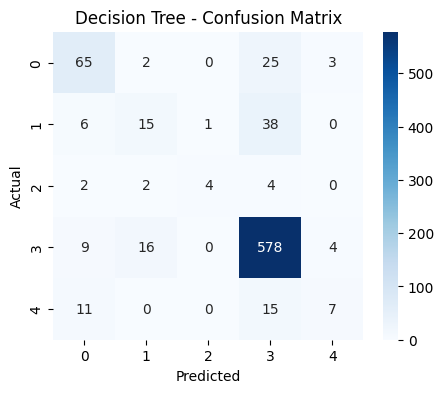

In [14]:


# For US data
dt_metrics_us = run_dt_workflow(prep_us)

In [25]:
def run_rf_workflow(prep):
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rf_search = RandomizedSearchCV(rf, param_grids['Random Forest'], n_iter=20, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    rf_search.fit(prep['X_train'], prep['y_train'])
    print("Best RF params:", rf_search.best_params_)
    best_rf = rf_search.best_estimator_

    rf_metrics = evaluate_and_store('Random Forest', best_rf, prep['X_train'], prep['X_test'], prep['y_train'], prep['y_test'])
    return rf_metrics



Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}

Random Forest - Test accuracy: 0.8377
Classification report (test):
               precision    recall  f1-score   support

           0       0.74      0.77      0.76        95
           1       0.47      0.13      0.21        60
           2       1.00      0.08      0.15        12
           3       0.86      0.97      0.91       607
           4       0.75      0.09      0.16        33

    accuracy                           0.84       807
   macro avg       0.77      0.41      0.44       807
weighted avg       0.82      0.84      0.80       807



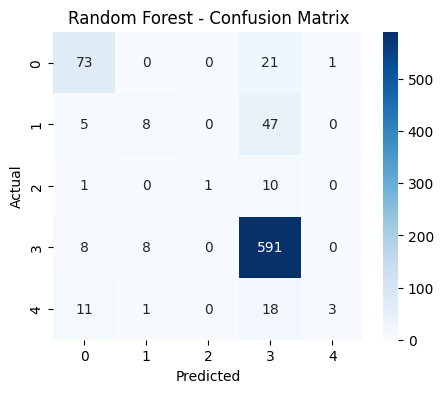

In [26]:
rf_metrics = run_rf_workflow(prep_us)  # for US data


In [ ]:
rf_metrics = run_rf_workflow(prep_uk)  # for UK data


In [27]:
def run_xgb_workflow(prep):
    xgb = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
    xgb_search = RandomizedSearchCV(xgb, param_grids['XGBoost'], n_iter=20, cv=3,
                                    scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    xgb_search.fit(prep['X_train'], prep['y_train'])
    print("Best XGB params:", xgb_search.best_params_)
    best_xgb = xgb_search.best_estimator_

    xgb_metrics = evaluate_and_store('XGBoost', best_xgb, prep['X_train'], prep['X_test'], prep['y_train'], prep['y_test'])
    return xgb_metrics


In [ ]:

xgb_metrics = run_xgb_workflow(prep_us)  # for US data


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:20:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:20:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:20:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:20:46] WARN

In [ ]:
xgb_metrics = run_xgb_workflow(prep_uk)  # for UK data

In [ ]:
def run_svm_workflow(prep):
    svm = SVC(random_state=RANDOM_STATE, probability=True)
    svm_search = RandomizedSearchCV(svm, param_grids['SVM'], n_iter=20, cv=3,
                                    scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)

    svm_search.fit(prep['X_train_scaled'], prep['y_train'])

    print("Best SVM params:", svm_search.best_params_)
    best_svm = svm_search.best_estimator_

    svm_metrics = evaluate_and_store('SVM', best_svm, prep['X_train_scaled'], prep['X_test_scaled'], prep['y_train'], prep['y_test'])
    return svm_metrics


In [ ]:
svm_metrics = run_svm_workflow(prep_us)

In [ ]:
svm_metrics = run_svm_workflow(prep_uk)



In [ ]:
def run_lr_workflow(prep):
    lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)
    lr_search = RandomizedSearchCV(lr, param_grids['Logistic Regression'], n_iter=20, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE)
    lr_search.fit(prep['X_train_scaled'], prep['y_train'])

    print("Best LR params:", lr_search.best_params_)
    best_lr = lr_search.best_estimator_

    lr_metrics = evaluate_and_store('Logistic Regression', best_lr,
                                   prep['X_train_scaled'], prep['X_test_scaled'],
                                   prep['y_train'], prep['y_test'])
    return lr_metrics


In [ ]:
lr_metrics_uk = run_lr_workflow(prep_uk)



In [ ]:
r_metrics_us = run_lr_workflow(prep_us)

In [ ]:
def summarize_and_plot_results(results_store, dataset_label=''):
    summary_rows = []
    for name, m in results_store.items():
        summary_rows.append({
            'Model': name,
            'Train Accuracy': m['train_accuracy'],
            'Test Accuracy': m['test_accuracy'],
            'Test Precision': m['test_precision'],
            'Test Recall': m['test_recall'],
            'Test F1': m['test_f1'],
            'Overfit (train-test)': m['train_accuracy'] - m['test_accuracy']
        })

    summary_df = pd.DataFrame(summary_rows).sort_values('Test Accuracy', ascending=False)
    print(f"Summary for {dataset_label} dataset:")
    display(summary_df)

    plt.figure(figsize=(8,4))
    sns.barplot(x='Model', y='Test Accuracy', data=summary_df)
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.title(f"Model test accuracy comparison ({dataset_label})")
    plt.show()

    return summary_df



In [ ]:
summary_uk = summarize_and_plot_results(results_store_uk, dataset_label='UK')


In [ ]:
summary_us = summarize_and_plot_results(results_store_us, dataset_label='US')


In [ ]:
import shap

def run_shap_rf(results_store, prep, dataset_label=''):
    try:
        model = results_store['Random Forest']['model']
        Xs = prep['X_test'].iloc[:200]  # limit for speed
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(Xs)

        print(f"SHAP summary plots for Random Forest on {dataset_label} dataset:")
        if isinstance(shap_values, list):
            # for multiclass, show class 1 (adjust if needed)
            shap.summary_plot(shap_values[1], Xs, feature_names=prep['feature_names'])
            shap.summary_plot(shap_values[1], Xs, plot_type="bar", feature_names=prep['feature_names'])
        else:
            shap.summary_plot(shap_values, Xs, feature_names=prep['feature_names'])
            shap.summary_plot(shap_values, Xs, plot_type="bar", feature_names=prep['feature_names'])
    except Exception as e:
        print(f"SHAP error for {dataset_label}:", e)



In [ ]:

run_shap_rf(results_store_us, prep_us, dataset_label='US')


In [ ]:
run_shap_rf(results_store_uk, prep_uk, dataset_label='UK')

In [ ]:
import lime.lime_tabular

def run_lime_rf_explanation(results_store, prep, dataset_label=''):
    try:
        model = results_store['Random Forest']['model']
        class_names = None
        if prep.get('label_encoder') is not None:
            class_names = list(prep['label_encoder'].classes_)
        else:
            class_names = [str(c) for c in sorted(prep['y_train'].unique())]

        explainer = lime.lime_tabular.LimeTabularExplainer(
            prep['X_train'].values,
            feature_names=prep['feature_names'],
            class_names=class_names,
            discretize_continuous=True
        )

        idx = 0  # change index to explain other test instances
        instance = prep['X_test'].iloc[idx].values
        explanation = explainer.explain_instance(instance, model.predict_proba, num_features=10)
        print(f"LIME explanation for Random Forest on {dataset_label} dataset, instance {idx}:")
        explanation.show_in_notebook(show_table=True)

    except Exception as e:
        print(f"LIME error for {dataset_label} dataset:", e)



In [ ]:

run_lime_rf_explanation(results_store_us, prep_us, dataset_label='US')


In [ ]:
run_lime_rf_explanation(results_store_uk, prep_uk, dataset_label='UK')